In [1]:
import sys
sys.path.append('../')   # If you move this notebook to another location, change this path to point to the root directory of the solutions project
import pandas as pd
from pathlib import Path
from solution import factory
from integrations import integration_base as base
from integrations import elc_integration as elc

# Preparation

There are three important manual steps that must take place before the Electricity Generation integration can be completed:
 
 1. If the reference TAM sources need to be updated, that should be done first.
 1. The current grid mix (percentage use of each technology in the integration year) must be set.
 1. For each of the PDS1, PDS2 and PDS3 scenarios, the choice of which corresponding scenario to use for each energy-generating solution must be made.  This will set the adoption of those energy sources within that scenario.
 1. Similarly, for each of the PDS1, PDS2 and PDS3 scenarios, the overall adoption profile for the conventional (+ "large hydro" and "other biomass") energy producing technologies must be set.
 
Note it is generally feasible to start with an approximate value to assess the impact on the results, then refine and try again.

### Initialize the Integration

In [2]:
# This box must be executed every time.
base.integration_clean()   # Uncomment this to remove the results of previous integration attempts
base.integration_start()
elc.setup(2018)             # Define the year we are integrating for

### Reference TAM

If the data sources for the refrence TAM need to be updated, do that directly in the data/elc directory.

### Grid Mix

In [3]:
# elc.load_historical_grid_mix()  retrieves the existing grid mixes.
# and once you have an updated version, you can save it (permanently) with elc.set_as_current_grid_mix(newmix)
# (You don't need to computee the percentages; that will be done automatically.)

elc.load_historical_grid_mix().head()

# elc.grid_mix_for_year(2018)                                  # look at the grid mix for a particular year
# elc.set_as_current_grid_mix( elc.grid_mix_for_year(2018) )   # re-use the previous grid mix

total                                             percent                              
                      2015          2016          2017          2018      2015      2016      2017      2018
technology                                                                                                  
coal          10075.050210  10169.496100  10259.450050  10345.491070  0.406194  0.400755  0.395827  0.393376
oil products    946.837525   5779.718251   5881.196183   5985.029627  0.038174  0.227764  0.226906  0.227574
natural gas    5688.980013   2606.000000   2679.300000   2715.000000  0.229362  0.102696  0.103372  0.103235
nuclear        2571.000000    929.652404    914.467314    899.084309  0.103655  0.036635  0.035282  0.034187
large hydro    3897.000000   4049.000000   4037.000000   4087.069600  0.157115  0.159561  0.155754  0.155406

### Scenario Choices

In [ ]:
# Customize the choices of scenario as needed.  If you have customizations here, you will need
# to execute this box every time.   (Alternatively, you can put the assignments in integration_base.py
# to make them permanent.)

# example assignment
# base.scenario_names['landfillmethane'] = ['scen_name1','scen_name2','scen_name3']   # etc.

In [4]:
#  Including any alterations you have made above, this is the current set of chosen scenarios

for s in elc.energy_solutions:
    print(f"{s}: {[factory.pds_truename(s,n) for n in base.scenario_names[s]]}")

onshorewind: ['PDS-20p2050-Plausible2020', 'PDS-27p2050-Drawdown2020', 'PDS-27p2050-Optimum2020']
offshorewind: ['PDS-4p2050-Plausible2020.', 'PDS-3p2050-Drawdown2020', 'PDS-6p2050-Optimum2020']
solarpvutil: ['PDS-20p2050-Plausible2020', 'PDS-25p2050-Drawdown2020', 'PDS-25p2050-Optimum2020']
solarpvroof: ['PDS-14p2050-Plausible2020', 'PDS-14p2050-Drawdown2020', 'PDS-14p2050-Optimum2020']
concentratedsolar: ['PDS-4p2050-Plausible (Book Ed. 1)', 'PDS-8p2050-Drawdown (Book Ed.1)', 'PDS-8p2050-Optimum (Book Ed.1)']
geothermal: ['PDS-3p2050-Plausible2020', 'PDS-3p2050-Drawdown2020', 'PDS-6p2050-Optimum2020']
waveandtidal: ['PDS-1p2050-Plausible2020', 'PDS-1p2050-Drawdown2020', 'PDS-2p2050-Optimum2020']
biomass: ['PDS-1p2050-Plausible2020', 'PDS-1p2050-Drawdown2020', 'PDS-1p2050-Optimum2020']
microwind: ['PDS-0p2050-Plausible2020', 'PDS-0p2050-Drawdown2020', 'PDS-0p2050-Optimum2020']
instreamhydro: ['PDS-2p2050-Plausible2020', 'PDS-2p2050-Drawdown2020', 'PDS-2p2050-Optimum2020']
nuclear: ['P

### Conventional Adoption Profile

In [4]:
# This will show you the existing adoption profile.  It is a large complex data structure, so you probably want to
# view it by slices, as shown below

adopt_profile = elc.load_conventional_adoption_profile()

Current conventional adoption profile loaded


<AxesSubplot:>

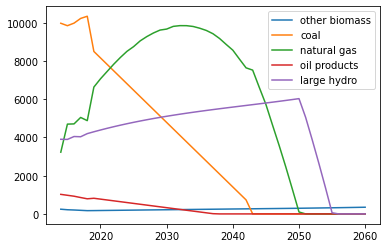

In [5]:

# Some ways to look at the data.   swaplevel is used to move one of the column headers to the top so you can select on it.

# adopt_profile['PDS1']                                    # entire structure for PDS1 only
# adopt_profile.swaplevel(1,0,axis=1)['large hydro']       # look at all three PDS for one technology
# adopt_profile.swaplevel(2,0,axis=1)['percent']           # Look at percents across 

# More on how to work with the adoption profile in the integration steps below.

adopt_profile['PDS1'].swaplevel(axis=1)['total'].plot()


In [13]:
# When you have an adoption profile that you want to work with, you can set it as follows.
#    NOTE/TODO: To make this a permanent change, save the data into the csv file as well.
#    new_profile.to_csv("./data/elc/conventional_adoption_profile.csv")

elc.use_conventional_adoption_profile(new_profile)


Setting conventional adoption profile


# Integration Steps

If you have already set up everything as required, and no further investigation is required, you can run the entire integration simply as follows:
```
elc.integrate()
```

Since you will probably need to do some further investigation to develop the conventional profile, we will walk you through the individual steps

### TAMs

In [3]:
# The first step calculates new integrated TAM.

elc.step1_calculate_tams()

Previously defined grid mix loaded for year 2018
Reference TAM sources loaded
Loading net energy deltas for all solutions; this takes some time
*** done.
integrated TAM calculated


In [4]:
# At this point, you can look at the TAM

elc.es.reference_tam.head(15)     # or elc.es.integrated_tam

Year
2014    22548.000000
2015    23915.294742
2016    24739.346398
2017    25546.280671
2018    26336.890715
2019    27111.969686
2020    27872.310736
2021    28618.707020
2022    29351.951693
2023    30072.837908
2024    30782.158821
2025    31480.707585
2026    32169.277355
2027    32848.661284
2028    33519.652528
Name: World, dtype: float64

<AxesSubplot:>

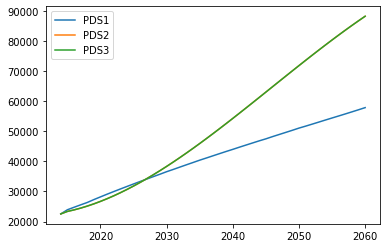

In [4]:
# or plot it

elc.es.integrated_tam.plot()

<AxesSubplot:>

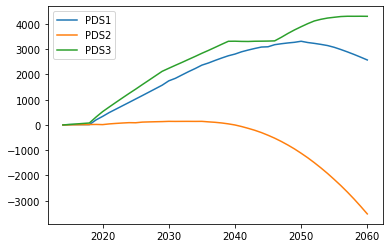

In [9]:
# You can also see the demand delta calculated from all the solutions

base.get_logitem("grid demand delta").plot()

In [10]:
# For convenience, you can also compare the new integrated TAM to the previous values

elc.integrated_tam_comparision()

PDS1                                     PDS2                                     PDS3                           
               old           new        delta           old           new        delta           old           new        delta
2012  21534.000000           NaN          NaN  21534.000000           NaN          NaN  21534.000000           NaN          NaN
2013  22203.000000           NaN          NaN  22203.000000           NaN          NaN  22203.000000           NaN          NaN
2014  22548.000000  22548.000000     0.000000  22548.000000  22548.000000     0.000000  22548.000000  22548.000000     0.000000
2015  24242.318098  23928.126071  -314.192026  24255.000000  23372.831327  -882.168673  24255.000000  23372.831327  -882.168673
2016  24876.033766  24754.290395  -121.743372  24919.000000  23883.477744 -1035.522256  24919.000000  23883.477744 -1035.522256
2017  25778.361890  25560.284331  -218.077559  25848.885255  24475.622548 -1373.262707  25848.885255  24475.622548 -1373.262707
2018  26247.975293  26350.024678   102.049384  26340.142418  25146.532377 -1193.610041  26340.142418  25146.532377 -1193.610041
2019  26795.588939  27309.394419   513.805481  25975.922807  25893.473865   -82.448942  25975.922807  25893.473865   -82.448942
2020  27469.605119  28210.301755   740.696636  26811.373316  26713.713649   -97.659667  26811.373316  26713.713649   -97.659667
2021  28113.811895  29108.666822   994.854926  27154.511464  27604.518365   450.006901  27154.511464  27604.518365   450.006901
2022  28776.614681  29975.221570  1198.606890  27754.964568  28563.154648   808.190080  27754.964568  28563.154648   808.190080
2023  29432.910480  30830.744433  1397.833953  28800.570737  29586.889135   786.318398  28800.570737  29586.889135   786.318398
2024  30083.281970  31674.000563  1590.718593  29927.866936  30672.988462   745.121526  29927.866936  30672.988462   745.121526
2025  30682.930260  32507.894335  1824.964075  31073.573019  31818.719264   745.146245  31073.573019  31818.719264   745.146245
2026  31370.088218  33331.060948  1960.972729  32407.030452  33021.348177   614.317725  32407.030452  33021.348177   614.317725
2027  32007.063892  34147.274665  2140.210773  33748.586639  34278.141838   529.555199  33748.586639  34278.141838   529.555199
2028  32639.062066  34955.337596  2316.275531  35151.267189  35586.366881   435.099693  35151.267189  35586.366881   435.099693
2029  33266.348909  35755.699029  2489.350120  36609.938031  36943.289944   333.351913  36609.938031  36943.289944   333.351913
2030  33827.279875  36584.236069  2756.956195  37975.552494  38346.177662   370.625168  37975.552494  38346.177662   370.625168
2031  34509.977367  37334.715597  2824.738230  39674.706946  39792.296671   117.589725  39674.706946  39792.296671   117.589725
2032  35126.964564  38113.907813  2986.943249  41270.524767  41278.913607     8.388840  41270.524767  41278.913607     8.388840
2033  35741.012493  38886.531235  3145.518743  42901.791987  42803.295106   -98.496881  42901.791987  42803.295106   -98.496881
2034  36354.424792  39646.092009  3291.667217  44563.387619  44362.707803  -200.679816  44563.387619  44362.707803  -200.679816
2035  36958.665611  40413.939776  3455.274165  46480.051992  45954.418336  -525.633657  46480.051992  45954.418336  -525.633657
2036  37578.311935  41131.938237  3553.626302  48063.799781  47575.693338  -488.106443  48063.799781  47575.693338  -488.106443
2037  38187.797794  41864.208386  3676.410592  49678.832607  49223.799448  -455.033159  49678.832607  49223.799448  -455.033159
2038  38795.885841  42589.923648  3794.037807  51410.407336  50896.003300  -514.404036  51410.407336  50896.003300  -514.404036
2039  39403.121486  43309.615711  3906.494225  53146.648209  52589.571530  -557.076680  53146.648209  52589.571530  -557.076680
2040  40068.534750  44008.945771  3940.411021  55059.174080  54301.770774  -757.403305  55059.174080  54301.770774  -757.403305
2041  40617.148445  44733.513110  4116.364665 

### Adoptions

In [4]:
# The second step collects the adoptions of all energy solutions for the chosen scenarios,
# and combines that with the conventional adoption profile.

elc.step2_calculate_adoptions()

loading previously-saved conventional adoption profile
Current conventional adoption profile loaded
Adoptions calculated


In [6]:
# At this point you can look at the reference or pds adoptions.
# Note that the total TWh numbers are used, and the percentages have been recalculated based on them.

# elc.es.ref_adoption.head(10)
elc.es.pds_adoption.head(10)

PDS1                                                                                                                                                                                     ...                      PDS3                                                                                                                                                
     Biomass (perennial corps) Concentrated Solar Power Distributed Solar Photovoltaics  Geothermal Landfill Methane Capture Large Methane Digesters Microwind      Nuclear Ocean Power Small Hydro (Small Hydro)  ... Small Hydro (Small Hydro) Utility Scale Solar Photovoltaics WIND OFFSHORE WIND ONSHORE Waste to Energy          coal  large hydro  natural gas oil products other biomass
2014                 62.540000                 9.000000                       75.000000   76.069500                23.802160               56.070860  1.228000  2417.000000    0.998800                547.670000  ...                547.670000                        112.630000     24.682000   687.046000       76.323108   9974.683447  3904.000000  4933.000000  1023.013184    246.263872
2015                 72.925668                 8.606552                      107.905685   77.356772                25.038474               58.765481  1.618431  2550.018747    2.078102                579.082382  ...                578.481296                        144.080000     36.210000   791.372000       95.126851   9846.991972  3897.000000  5688.980013   974.747567    211.327056
2016                 83.881219                 7.998265                      150.060940   85.145256                27.532068               65.835473  1.921645  2639.499619    2.971183                602.386637  ...                607.789924                        188.436000     41.596000   913.054000      104.106739   9980.792467  4049.000000  5779.718251   926.481950    197.421931
2017                 95.191107                10.210737                      193.993763   95.594503                30.008455               73.431693  2.239072  2731.263528    3.508085                624.511173  ...                635.927377                        255.486000     57.331000  1077.120000      113.924569  10226.892210  4037.000000  5881.196183   857.154382    180.752700
2018                106.829622                15.382517                      240.253269  108.604298                32.467635               81.518982  2.570509  2825.165692    3.776891                645.502023  ...                662.928500                        613.956563     80.317400  1622.090429      124.613251  10341.486729  4200.440717  5985.029627   790.409473    163.523289
2019                118.771054                23.652152                      289.388574  124.074425                34.909606               90.062183  2.915753  2921.061328    3.865680                665.405218  ...                688.828142                        790.923091    114.724945  2113.345727      138.036237   8498.460937  4297.489770  5192.494485   818.537441    166.743936
2020                130.989692                35.158191                      341.948793  141.904666                37.334371               99.026138  3.274601  3018.805653    3.862532                684.266791  ...                713.661149                       1059.767730    145.756106  2536.993584      151.480057   8160.861250  4389.987964  5308.697272   773.750058    166.448756
2021                143.459826                50.039183                      398.483043  161.994805                39.741928              108.375690  3.646851  3118.253885    3.855528                702.132772  ...                737.462368                       1411.577117    200.290171  2996.080106      165.987867   7823.261562  4478.133374  4762.960713   728.962676    168.579006
2022                156.155745                68.433675                      459.540438  184.244627                42.132277              118.075681  4.032299  3219.261242    3

<AxesSubplot:>

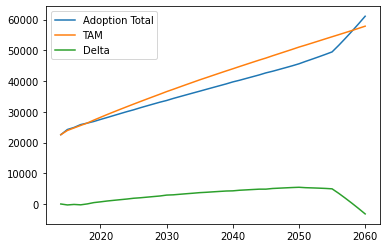

In [5]:
# Compare the an adoption to the corresponding TAM

elc.compare_adoption_to_tam(segment='PDS1').plot()   # setgment = 'reference', 'PDS1', 'PDS2' or 'PDS3'

In [ ]:
# If they don't match up, modify the conventional adoption profile, and try again.
# TODO: in the future we could provide tools to help with that, perhaps.

### Grid Emissions

In [5]:
elc.step3_calculate_emissions()

Grid Emissions factors calculated


### Save

Up until now, results have been calculated in memory only.
This step will cause following files to be updated:

 * Integrated Energy TAM
 * Grid Emissions used by all solutions
 * Final conventional adoption profile with calculated percentages

In [6]:
elc.step4_update()

Grid Emissions Data Updated


ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

# Developer Section
Ignore everything from here on down... Or use this space yourself for scratch work.

In [8]:
elc.es.integrated_tam['PDS1'].reset_index().head()

,index,PDS1
0,2014,22548.000000
1,2015,23928.126071
2,2016,24754.290395
3,2017,25560.284331
4,2018,26350.024678


In [3]:
elc.load_emissions_factors()

In [4]:
elc.es.emissions_factors

,avg,high,low
coal,1028.250000,1250.948610,805.551391
oil products,828.220000,1047.551515,608.888485
natural gas,574.074333,746.915318,401.233349
other biomass,621.545000,901.950000,457.024000
nuclear,18.459400,45.196413,0.800000
hydro,202.264783,703.944985,0.000000
instreamhydro,24.688800,65.572539,0.500000
solarpvutil,46.913333,74.865256,16.100000
solarpvroof,50.378182,79.429104,21.327260
concentratedsolar,49.904000,114.137737,5.000000


In [5]:
base.integration_start(False)

In [6]:
elc.load_emissions_factors()

In [7]:
elc.es.emissions_factors

,avg,high,low
coal,1028.250000,1250.948610,805.551390
natural gas,574.074333,746.915318,401.233349
large hydro,202.264783,703.944985,0.000000
oil products,828.220000,1047.551515,608.888485
other biomass,621.545000,901.950000,457.024000
onshorewind,22.466897,43.918210,1.015583
offshorewind,14.251818,22.389450,6.114186
solarpvutil,46.913333,74.865256,18.961411
solarpvroof,50.378182,79.429104,21.327260
concentratedsolar,41.941667,94.027363,5.000000


In [7]:
%debug

> c:\programdata\miniconda3\envs\foo\lib\site-packages\pandas\core\generic.py(462)_get_axis_number()
    460             return cls._AXIS_TO_AXIS_NUMBER[axis]
    461         except KeyError:
--> 462             raise ValueError(f"No axis named {axis} for object type {cls.__name__}")
    463 
    464     @final

ipdb> up 9
> c:\working\solutions\integrations\elc_integration.py(460)step4_update()
    458     # Create updated versions of each of the data files, and then also the updated json file
    459     munge = lambda x: df_to_csv_string(x.set_axis(['Year','World'],axis=1))
--> 460     update_to_version(public_datadir/"PDS_plausible_scenario.csv", version, munge(es.integrated_tam['PDS1']))
    461     update_to_version(public_datadir/"PDS_drawdown_scenario.csv", version, munge(es.integrated_tam['PDS2']))
    462     update_to_version(public_datadir/"PDS_optimum_scenario.csv", version, munge(es.integrated_tam['PDS3']))

ipdb> es.integrated_tam['PDS1'].head()
2014    22548.000000
2015

In [9]:
base.get_logitem("pds tam").head()

,PDS1,PDS2,PDS3
2014,22548.000000,22548.000000,22548.000000
2015,23928.126071,23919.323063,23933.943979
2016,24754.290395,24747.027411,24777.430470
2017,25560.284331,25557.625464,25603.790850
2018,26350.024678,26351.899322,26413.872300


In [10]:
base.get_logitem("grid demand delta").head()

,PDS1,PDS2,PDS3
2014,0.000000,0.000000,0.000000
2015,12.831330,4.028322,18.649237
2016,14.943997,7.681014,38.084072
2017,14.003660,11.344793,57.510179
2018,13.133962,15.008607,76.981585


In [12]:
elc.es.net_grid_use.head()

altcement                    bikeinfrastructure      buildingautomation           carpooling       ...  telepresence trains           waterdistribution                    waterefficiency                         
              PDS1 PDS2          PDS3               PDS1 PDS2               PDS1 PDS2 PDS3       PDS1 PDS2  ...          PDS3   PDS1 PDS2 PDS3              PDS1 PDS2          PDS3            PDS1          PDS2       PDS3
2014  0.000000e+00  0.0  0.000000e+00                0.0  0.0           0.000000  0.0  0.0        0.0  0.0  ...  0.000000e+00    0.0  0.0  0.0          0.000000  0.0  0.000000e+00    0.000000e+00  0.000000e+00   0.000000
2015  0.000000e+00  0.0  0.000000e+00                0.0  0.0           8.249938  0.0  0.0        0.0  0.0  ...  0.000000e+00    0.0  0.0  0.0          3.725416  0.0  0.000000e+00   -1.355031e+00  0.000000e+00  10.414771
2016  0.000000e+00  0.0  0.000000e+00                0.0  0.0           3.485661  0.0  0.0        0.0  0.0  ...  0.000000e+00    0.0  0.0  0.0          7.450831  0.0  0.000000e+00   -8.805396e-01  0.000000e+00  20.829541
2017  0.000000e+00  0.0  0.000000e+00                0.0  0.0          -4.273729  0.0  0.0        0.0  0.0  ...  0.000000e+00    0.0  0.0  0.0         11.176247  0.0  0.000000e+00   -4.277478e-01  0.000000e+00  31.244312
2018  3.326520e-12  0.0 -9.906900e-13                0.0  0.0         -12.033120  0.0  0.0        0.0  0.0  ...  4.669680e-12    0.0  0.0  0.0         14.901662  0.0 -8.350750e-14    4.255370e-13  1.655430e-13  41.659083

[5 rows x 74 columns]

In [ ]:
import sys
sys.path.append('../')   # If you move this notebook to another location, change this path to point to the root directory of the solutions project
import pandas as pd
from pathlib import Path
from solution import factory
from integrations import integration_base as base
from integrations import elc_integration as elc
base.integration_clean()   # Uncomment this to remove the results of previous integration attempts
base.integration_start(True)
elc.setup(2018)   

In [3]:
elc.step1_calculate_tams()
elc.step2_calculate_adoptions()
elc.step3_calculate_emissions()
elc.step4_update()

Previously defined grid mix loaded for year 2018
Reference TAM sources loaded
Loading net energy deltas for all solutions; this takes some time
*** done.
integrated TAM calculated
loading previously-saved conventional adoption profile
Current conventional adoption profile loaded
Adoptions calculated
Grid Emissions factors calculated
Grid Emissions Data Updated
PDS (Integrated) TAM upated


In [4]:
from io import StringIO
def df_to_csv_string(df):
    buffer = StringIO()
    df.to_csv(buffer, line_terminator='\n')
    return buffer.getvalue()

In [7]:
elc.es.integrated_tam.head()

,PDS1,PDS2,PDS3
Year,,,
2014,22548.000000,22548.000000,22548.000000
2015,23928.126071,23372.831327,23372.831327
2016,24754.290395,23883.477744,23883.477744
2017,25560.284331,24475.622548,24475.622548
2018,26350.024678,25146.532377,25146.532377


In [8]:
df_to_csv_string(elc.es.integrated_tam.head())

'Year,PDS1,PDS2,PDS3\n2014,22548.0,22548.0,22548.0\n2015,23928.12607147136,23372.83132703971,23372.83132703971\n2016,24754.29039468282,23883.47774360618,23883.47774360618\n2017,25560.284331120463,24475.622548167015,24475.622548167015\n2018,26350.02467770569,25146.53237665045,25146.53237665045\n'